How to start the sglang server?
```bash
python -m sglang.launch_server --model-path /data/chenjunyi/models/qwen2-7b-chat/ --port 9999 --max-total-token 2048 --disable-radix-cache
```
We limited the max-total-token to simulate the memory constraint environment, use disable-radix-cache to shut down the prompt cache.

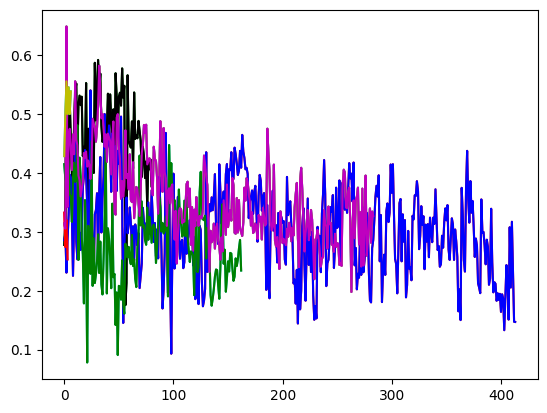

In [4]:
def draw_image_from_file():
    file = open('tmp/attention1.txt', 'r')
    lines = file.readlines()
    x = []
    y = []
    prev_a = -1
    list_idx = -1
    for line in lines:
        _, a, b = line.split(' ')
        a = int(a)
        b = float(b)
        if prev_a == -1 or a - prev_a != 1:
            prev_a = a
            x.append([])
            y.append([])
            list_idx += 1
        x[list_idx].append(a - prev_a)
        y[list_idx].append(b)
        prev_a = a
    # draw a line chart, different color for different x[i]
    import matplotlib.pyplot as plt
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i in range(len(x)):
        # using the accordingly x-axis number
        plt.plot(y[i], color=colors[i % len(colors)])
    plt.show()
    # plt.savefig('tmp/attention1.png')
draw_image_from_file()

In [6]:
import requests
from pprint import pprint

url = "http://localhost:9999/generate"

data = {
    "text": ["What is AI?"],
    "sampling_params": {
        "temperature": 0,
        "max_new_tokens": 32,
    },
}

response = requests.post(url, json=data)
pprint(response.json())

[{'index': 0,
  'meta_info': {'cached_tokens': 0,
                'completion_tokens': 32,
                'completion_tokens_wo_jump_forward': 32,
                'finish_reason': {'length': 32, 'type': 'length'},
                'id': 'b3728b07fbd3466da6af3cb80d849922',
                'prompt_tokens': 4},
  'text': ' How does it work? How can it be used to solve real-world problems? '
          'In this course, you will learn about the basics of artificial '
          'intelligence, including the'}]


In [2]:
import os
os.system("~/miniconda3/envs/sglang/bin/python -m sglang.bench_serving  \
                                        --port 9999 \
                                        --backend sglang \
                                        --num-prompts 5 \
                                        --dataset-name random \
                                        --dataset-path /home/chenjunyi/project/vllm/benchmarks/ShareGPT_V3_unfiltered_cleaned_split.json \
                                        --random-input 512 \
                                        --random-output 512")
# os.system("~/miniconda3/envs/sglang/bin/python benchmark/benchmark_serving.py  \
#                         --port 9999 \
#                         --backend sglang \
#                         --dataset /home/chenjunyi/project/vllm/benchmarks/ShareGPT_V3_unfiltered_cleaned_split.json \
#                         --model /data/chenjunyi/models/qwen2-7b-chat/ \
#                         --num-prompts 50")

Namespace(backend='sglang', base_url=None, host='0.0.0.0', port=9999, dataset_name='random', dataset_path='/home/chenjunyi/project/vllm/benchmarks/ShareGPT_V3_unfiltered_cleaned_split.json', model='/data/chenjunyi/models/qwen2-7b-chat/', tokenizer=None, num_prompts=5, sharegpt_output_len=None, random_input_len=512, random_output_len=512, random_range_ratio=0.0, request_rate=inf, seed=1, multi=False, request_rate_range='2,34,2', output_file=None, disable_tqdm=False, disable_stream=False, disable_ignore_eos=False, extra_request_body=None)

#Input tokens: 1000
#Output tokens: 1452
Starting initial single prompt test run...
Initial test run completed. Starting main benchmark run...


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]



============ Serving Benchmark Result ============
Backend:                                 sglang    
Traffic request rate:                    inf       
Successful requests:                     5         
Benchmark duration (s):                  5.72      
Total input tokens:                      1000      
Total generated tokens:                  1452      
Total generated tokens (retokenized):    1452      
Request throughput (req/s):              0.87      
Input token throughput (tok/s):          174.96    
Output token throughput (tok/s):         254.04    
----------------End-to-End Latency----------------
Mean E2E Latency (ms):                   3376.27   
Median E2E Latency (ms):                 3275.70   
---------------Time to First Token----------------
Mean TTFT (ms):                          185.17    
Median TTFT (ms):                        209.35    
P99 TTFT (ms):                           210.23    
-----Time per Output Token (excl. 1st token)------
Mean TPOT (ms):

0

In [ ]:
import torch
from sglang.srt.layers.attention.triton_ops.extend_attention import extend_attention_fwd

def _test_extend_attention_once(B, N_CTX, H_Q, H_KV, D):
    dtype = torch.bfloat16

    b_seq_len_prefix = torch.randint(
        1, N_CTX // 2, (B,), dtype=torch.int32, device="cuda"
    )
    b_seq_len_extend = torch.randint(
        1, N_CTX // 2, (B,), dtype=torch.int32, device="cuda"
    )
    b_seq_len = b_seq_len_prefix + b_seq_len_extend
    max_len_in_batch = torch.max(b_seq_len, 0)[0].item()

    b_req_idx = torch.arange(B, dtype=torch.int32, device="cuda")
    req_to_tokens = torch.empty(
        (B, max_len_in_batch), dtype=torch.int32, device="cuda"
    )
    b_start_loc = torch.zeros((B,), dtype=torch.int32, device="cuda")
    b_start_loc[1:] = torch.cumsum(b_seq_len[:-1], 0)
    b_start_loc_extend = torch.zeros((B,), dtype=torch.int32, device="cuda")
    b_start_loc_extend[1:] = torch.cumsum(b_seq_len_extend[:-1], 0)
    for i in range(B):
        req_to_tokens[i, : b_seq_len[i]] = torch.arange(
            b_start_loc[i], b_start_loc[i] + b_seq_len[i]
        )

    total_token_num = torch.sum(b_seq_len).item()
    extend_token_num = torch.sum(b_seq_len_extend).item()
    k_buffer = torch.empty(
        (total_token_num, H_KV, D), dtype=dtype, device="cuda"
    ).normal_(mean=0.1, std=0.2)
    v_buffer = torch.empty(
        (total_token_num, H_KV, D), dtype=dtype, device="cuda"
    ).normal_(mean=0.1, std=0.2)

    k_extend = torch.empty((extend_token_num, H_KV, D), dtype=dtype, device="cuda")
    v_extend = torch.empty((extend_token_num, H_KV, D), dtype=dtype, device="cuda")
    q_extend = torch.empty((extend_token_num, H_Q, D), dtype=dtype, device="cuda")
    for i in range(B):
        extend_start_in_buffer = b_start_loc[i] + b_seq_len_prefix[i]
        extend_end_in_buffer = b_start_loc[i] + b_seq_len[i]
        extend_start = b_start_loc_extend[i]
        extend_end = b_start_loc_extend[i] + b_seq_len_extend[i]
        k_extend[extend_start:extend_end] = k_buffer[
            extend_start_in_buffer:extend_end_in_buffer
        ]
        v_extend[extend_start:extend_end] = v_buffer[
            extend_start_in_buffer:extend_end_in_buffer
        ]
        q_extend[extend_start:extend_end] = torch.empty(
            (b_seq_len_extend[i], H_Q, D), dtype=dtype, device="cuda"
        ).normal_(mean=0.1, std=0.2)

    o_extend = torch.empty((extend_token_num, H_Q, D), dtype=dtype, device="cuda")
    o_redundant = torch.empty(
        (extend_token_num, H_Q, D), dtype=dtype, device="cuda"
    )

    b_seq_len_extend = b_seq_len - b_seq_len_prefix
    b_start_loc_extend = torch.zeros_like(b_seq_len)
    b_start_loc_extend[1:] = torch.cumsum(b_seq_len_extend[:-1], 0)
    max_len_extend = torch.max(b_seq_len_extend, 0)[0].item()
    extend_attention_fwd(
        q_extend,
        k_extend,
        v_extend,
        o_extend,
        k_buffer,
        v_buffer,
        req_to_tokens,
        b_req_idx,
        b_seq_len,
        b_seq_len_extend,
        b_start_loc_extend,
        max_len_extend,
    )
_test_extend_attention_once(2, 8, 8, 8, 8)

CompilationError: at 103:13:

        # load k in transposed way
        offs_buf_k = (
            offs_kv_loc[None, :] * stride_buf_kbs
            + cur_kv_head * stride_buf_kh
            + offs_d[:, None]
        )
        k = tl.load(
            K_Buffer + offs_buf_k, mask=(mask_n[None, :]) & (mask_d[:, None]), other=0.0
        )

        qk = tl.dot(q.to(k.dtype), k)
             ^